In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Generate a data set with covariance matrix from the original plus gaussian noise

In [3]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.05 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

(1000, 31, 31)


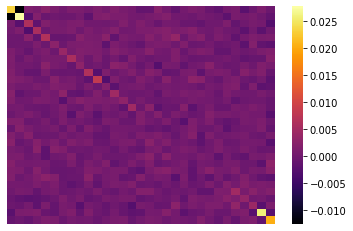

In [4]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [5]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)                0     

In [6]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [7]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test))
#                 callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
25/25 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 6.9178e-05
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 2.3554e-04 - val_loss: 1.9684e-05
Epoch 3/500
25/25 [==============================] - 0s 3ms/step - loss: 9.9808e-05 - val_loss: 1.0244e-05
Epoch 4/500
25/25 [==============================] - 0s 3ms/step - loss: 6.6576e-05 - val_loss: 6.5609e-06
Epoch 5/500
25/25 [==============================] - 0s 3ms/step - loss: 4.7927e-05 - val_loss: 4.6029e-06
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 3.6664e-05 - val_loss: 3.6281e-06
Epoch 7/500
25/25 [==============================] - 0s 3ms/step - loss: 2.9529e-05 - val_loss: 2.9244e-06
Epoch 8/500
25/25 [==============================] - 0s 3ms/step - loss: 2.3885e-05 - val_loss: 2.4859e-06
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 2.0909e-05 - val_loss: 2.1632e-06
Epoch 10/500
25/25 [====================

Epoch 77/500
25/25 [==============================] - 0s 3ms/step - loss: 1.5291e-06 - val_loss: 1.0442e-06
Epoch 78/500
25/25 [==============================] - 0s 3ms/step - loss: 1.5370e-06 - val_loss: 1.0458e-06
Epoch 79/500
25/25 [==============================] - 0s 3ms/step - loss: 1.5024e-06 - val_loss: 1.0422e-06
Epoch 80/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4854e-06 - val_loss: 1.0430e-06
Epoch 81/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4890e-06 - val_loss: 1.0413e-06
Epoch 82/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4613e-06 - val_loss: 1.0421e-06
Epoch 83/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4399e-06 - val_loss: 1.0372e-06
Epoch 84/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4631e-06 - val_loss: 1.0413e-06
Epoch 85/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4219e-06 - val_loss: 1.0450e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 3ms/step - loss: 1.1687e-06 - val_loss: 1.0515e-06
Epoch 153/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1682e-06 - val_loss: 1.0482e-06
Epoch 154/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1615e-06 - val_loss: 1.0506e-06
Epoch 155/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1689e-06 - val_loss: 1.0453e-06
Epoch 156/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1619e-06 - val_loss: 1.0500e-06
Epoch 157/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1680e-06 - val_loss: 1.0538e-06
Epoch 158/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1605e-06 - val_loss: 1.0550e-06
Epoch 159/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1657e-06 - val_loss: 1.0528e-06
Epoch 160/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1622e-06 - val_loss: 1.0525e-06
Epoch 161/500
25/25 [============

25/25 [==============================] - 0s 3ms/step - loss: 1.1110e-06 - val_loss: 1.0489e-06
Epoch 228/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1013e-06 - val_loss: 1.0588e-06
Epoch 229/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1052e-06 - val_loss: 1.0613e-06
Epoch 230/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1082e-06 - val_loss: 1.0550e-06
Epoch 231/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1035e-06 - val_loss: 1.0620e-06
Epoch 232/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1055e-06 - val_loss: 1.0509e-06
Epoch 233/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1003e-06 - val_loss: 1.0506e-06
Epoch 234/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0990e-06 - val_loss: 1.0486e-06
Epoch 235/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0983e-06 - val_loss: 1.0539e-06
Epoch 236/500
25/25 [============

25/25 [==============================] - 0s 3ms/step - loss: 1.0791e-06 - val_loss: 1.0545e-06
Epoch 303/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0822e-06 - val_loss: 1.0540e-06
Epoch 304/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0842e-06 - val_loss: 1.0529e-06
Epoch 305/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0780e-06 - val_loss: 1.0570e-06
Epoch 306/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0819e-06 - val_loss: 1.0516e-06
Epoch 307/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0787e-06 - val_loss: 1.0566e-06
Epoch 308/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0754e-06 - val_loss: 1.0495e-06
Epoch 309/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0799e-06 - val_loss: 1.0559e-06
Epoch 310/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0801e-06 - val_loss: 1.0559e-06
Epoch 311/500
25/25 [============

25/25 [==============================] - 0s 3ms/step - loss: 1.0716e-06 - val_loss: 1.0546e-06
Epoch 378/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0708e-06 - val_loss: 1.0557e-06
Epoch 379/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0683e-06 - val_loss: 1.0559e-06
Epoch 380/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0701e-06 - val_loss: 1.0548e-06
Epoch 381/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0692e-06 - val_loss: 1.0549e-06
Epoch 382/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0669e-06 - val_loss: 1.0499e-06
Epoch 383/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0705e-06 - val_loss: 1.0556e-06
Epoch 384/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0688e-06 - val_loss: 1.0547e-06
Epoch 385/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0644e-06 - val_loss: 1.0588e-06
Epoch 386/500
25/25 [============

25/25 [==============================] - 0s 3ms/step - loss: 1.0652e-06 - val_loss: 1.0516e-06
Epoch 453/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0611e-06 - val_loss: 1.0541e-06
Epoch 454/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0669e-06 - val_loss: 1.0548e-06
Epoch 455/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0636e-06 - val_loss: 1.0608e-06
Epoch 456/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0654e-06 - val_loss: 1.0553e-06
Epoch 457/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0659e-06 - val_loss: 1.0513e-06
Epoch 458/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0644e-06 - val_loss: 1.0522e-06
Epoch 459/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0645e-06 - val_loss: 1.0482e-06
Epoch 460/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0635e-06 - val_loss: 1.0539e-06
Epoch 461/500
25/25 [============

(array([-0.0002,  0.    ,  0.0002,  0.0004,  0.0006,  0.0008,  0.001 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

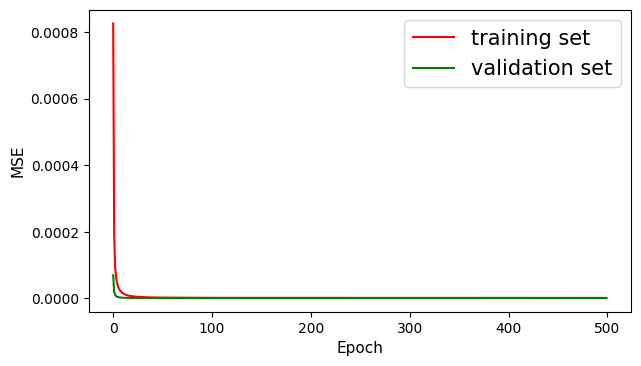

In [8]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [9]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.0372408496550631e-06 1.0601953590594348e-06


In [10]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(200, 31)


(200, 961)


<AxesSubplot:>

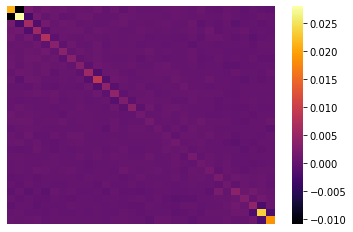

In [11]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


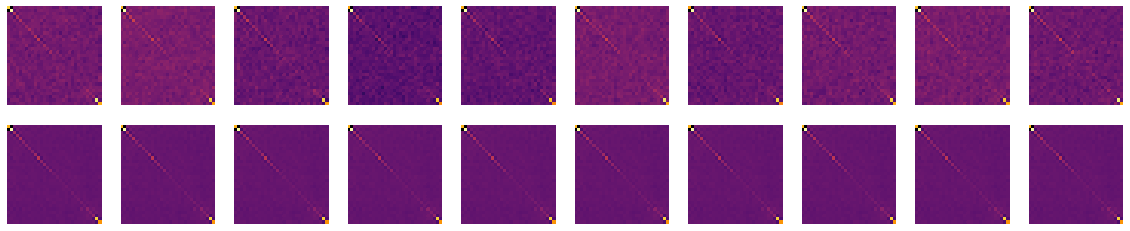

In [12]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [14]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

In [15]:
fake_encoded = np.zeros((1, 31))
avg_encoded = np.mean(encoded_imgs, axis=0)
ranz = z

In [16]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/z[i]
    fake_encoded[0, i] = alpha * ranz[i]

In [17]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

In [18]:
# decoded_fake[0, :]

1.33496e-06

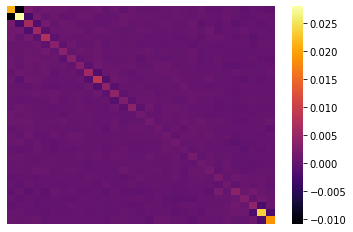

In [19]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
# plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

In [20]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")


In [21]:
# Guardar modelos
autoencoder.save('autoencoderJLA.h5')
decoder.save('decoderJLA.h5')
encoder.save('encoderJLA.h5')
# neural_model.save('FFNN_JLA.h5')